In [86]:
import os
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from arch import arch_model
from tqdm import tqdm
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import logging
from scipy.stats import pearsonr, spearmanr, kendalltau
from sklearn.metrics import mean_squared_error, r2_score
from dataprocessing import build_features

In [147]:
# -----------------------
# Reproducibility
# -----------------------
SEED = 0
np.random.seed(SEED)
# xgboost uses seed param inside params
# -----------------------
# Logging
# -----------------------
logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(message)s")
log = logging.getLogger("vol_demo")

In [148]:
X = pd.read_csv('/home/tatiana/Downloads/supp_material/X_train.csv')
Y = pd.read_csv('/home/tatiana/Downloads/supp_material/y_train.csv')

df = build_features(X, Y, add_target=True)   

## Data description
- This data was taken from a ML challenge competition, therefore I am not sure I can freely post the datasets. In case of interest, you can easily retrieve the data here: https://challengedata.ens.fr/participants/challenges/97/ 
- X contains 35 columns of self-explanatory exogenous variables related to a coupled power market of France and Germany. See print of the variables names here:
  ['ID', 'DAY_ID', 'COUNTRY', 'DE_CONSUMPTION', 'FR_CONSUMPTION', 'DE_FR_EXCHANGE', 'FR_DE_EXCHANGE', 'DE_NET_EXPORT', 'FR_NET_EXPORT', 'DE_NET_IMPORT', 'FR_NET_IMPORT', 'DE_GAS', 'FR_GAS', 'DE_COAL', 'FR_COAL', 'DE_HYDRO', 'FR_HYDRO', 'DE_NUCLEAR', 'FR_NUCLEAR', 'DE_SOLAR', 'FR_SOLAR', 'DE_WINDPOW', 'FR_WINDPOW', 'DE_LIGNITE', 'DE_RESIDUAL_LOAD', 'FR_RESIDUAL_LOAD', 'DE_RAIN', 'FR_RAIN', 'DE_WIND', 'FR_WIND', 'DE_TEMP', 'FR_TEMP', 'GAS_RET', 'COAL_RET', 'CARBON_RET']

- Y contains price changes for daily futures contracts of 24H electricity baseload for these countries. X and Y datasets have an 'ID' variable as a common identifier.
- Attention! ID != DAY_ID, therefore I sorted them first by ID, then just merged sorted X and Y into one Dataframe, then sorted by DAY_ID to set the time sequence correctly.
- Some days contain information for both countries, some only for FR or DE. Needs to be taken into account when computing lags per country etc.
- Please see all manipulations and engineered features additions in dataprocessing.py file containing build_features function, here I already use the resulting dataframe.

## GARCH part

In [149]:
# -----------------------
# GARCH rolling forecast per country (leak-free) - keep start/end indices explicit
# -----------------------
garch_window = 500
min_obs = 300

# Create garch_vol and store successful fit count
df = df.sort_values(['COUNTRY','DAY_ID']).reset_index(drop=True)
df['garch_vol'] = np.nan
#df['garch_stdresid'] = np.nan  # standardized residual

for country in df['COUNTRY'].unique():
    df_c_idx = df[df['COUNTRY']==country].index
    returns = df.loc[df_c_idx, 'volatility'].values

    success_count = 0
    for local_t in range(len(returns)):
        if local_t < min_obs:
            continue
        start = max(0, local_t - garch_window)
        end = local_t  # up to t-1
        window = returns[start:end]
        if len(window) < min_obs:
            continue
        try:
            am = arch_model(window, vol='Garch', p=1, q=1, dist='t', rescale=False)
            res = am.fit(disp='off', update_freq=0, show_warning=False)
            fcast = res.forecast(horizon=1, reindex=False)
            sigma_t = np.sqrt(fcast.variance.values[-1,0])
            # place into global df at corresponding index
            global_idx = df_c_idx[start + (len(window))] if False else df_c_idx[local_t]
            df.loc[df_c_idx[local_t], 'garch_vol'] = sigma_t
            # compute standardized residual for local_t (current observed vol / sigma)
            #std_resid = returns[local_t] / (sigma_t + eps)
            #df.loc[df_c_idx[local_t], 'garch_stdresid'] = std_resid
            #success_count += 1
        except Exception as e:
            # log once per exception type if needed
            continue
    success_count = df.loc[df['COUNTRY']==country, 'garch_vol'].notna().sum()
    log.info(f'Country {country}: successful GARCH preds: {int(success_count)}')

# Drop rows without garch forecast (cannot build residual)
df = df.dropna(subset=['garch_vol']).reset_index(drop=True)
log.info(f'After dropping NaN garch_vol rows, {len(df)} observations remain')

2026-02-10 16:39:53,886 INFO Country DE: successful GARCH preds: 343
2026-02-10 16:40:14,723 INFO Country FR: successful GARCH preds: 551
2026-02-10 16:40:14,724 INFO After dropping NaN garch_vol rows, 894 observations remain


## ML part

In [150]:
# raw residual
df['residual_target'] = df['volatility'] - df['garch_vol']

# optional smoothed target for experiments, backwards smoothing --> no data leakage
df['residual_target_smooth'] = (
    df.groupby('COUNTRY')['residual_target']
      .transform(lambda x: x.shift(1).rolling(5, min_periods=1).mean())
)

In [151]:
FEATURE_POOL = [
    # Vol memory
    'vol_lag1','vol_lag3','vol_lag7',
    'vol_roll_std_7','vol_roll_std_30',

    # Load & imbalance
    'DE_RESIDUAL_LOAD_lag1','FR_RESIDUAL_LOAD_lag1',
    'LOAD_IMBALANCE','FLOW_PRESSURE','TOTAL_FLOW',
    'DE_RESIDUAL_STRESS','FR_RESIDUAL_STRESS', 'WIND_IMBALANCE', 'SOLAR_IMBALANCE', 'NUCLEAR_IMBALANCE',

    # Fuel / carbon
    'GAS_COAL_SPREAD','CARBON_PRESSURE',

    # Renewables
    'REL_RENEWABLE',

    # Regimes
    'GAS_RET_30m','LOAD_TREND_30' , 'LOADxGAS',

    'DE_TEMP_ANOM', 'FR_TEMP_ANOM', 'DE_WIND_ANOM', 'FR_WIND_ANOM', 'DE_RAIN_ANOM', 
    'FR_RAIN_ANOM', 'DE_RESIDUAL_LOAD_rm_3', 'DE_RESIDUAL_LOAD_std_3', 'DE_RESIDUAL_LOAD_rm_7',
    'DE_RESIDUAL_LOAD_std_7', 'DE_RESIDUAL_LOAD_rm_30', 'DE_RESIDUAL_LOAD_std_30', 
    'FR_RESIDUAL_LOAD_rm_3', 'FR_RESIDUAL_LOAD_std_3', 'FR_RESIDUAL_LOAD_rm_7', 'FR_RESIDUAL_LOAD_std_7', 
    'FR_RESIDUAL_LOAD_rm_30', 'FR_RESIDUAL_LOAD_std_30',
]

In [152]:
def score_features_production(feature_subset, df, train_window, test_horizon, params, gap_days=1):
    """
    CORRECTED: Proper nested CV for feature scoring.
    
    Key changes:
    1. Uses expanding window (not rolling) to maximize data
    2. Adds gap between train/test
    3. Each fold only sees data BEFORE it (no future data)
    
    Parameters:
    -----------
    feature_subset : list of str
        Features to evaluate
    df : DataFrame
        Data with DAY_ID, COUNTRY, residual_target, and features
    train_window : int
        MINIMUM number of days for training (not used as rolling window anymore)
    test_horizon : int
        Number of days to test at once
    params : dict
        XGBoost parameters
    gap_days : int
        Gap between train and test (default 1 to prevent same-day leakage)
    
    Returns:
    --------
    float : Mean Spearman correlation across test folds
    """
    rhos = []
    unique_days = np.sort(df['DAY_ID'].unique())
    
    # Start testing after we have enough training data + gap
    start_idx = train_window + gap_days
    
    # CORRECTED: Expanding window approach
    for i in range(start_idx, len(unique_days) - test_horizon + 1, test_horizon):
        
        # EXPANDING WINDOW: Use ALL data up to point i (not just last train_window days)
        train_days = unique_days[:i]  # Everything before test period
        
        # GAP: Skip gap_days to prevent look-ahead
        # TEST: Next test_horizon days after gap
        test_days = unique_days[i + gap_days : i + gap_days + test_horizon]
        
        if len(test_days) == 0:
            continue
        
        tr = df['DAY_ID'].isin(train_days)
        te = df['DAY_ID'].isin(test_days)
        
        X_tr = df.loc[tr, feature_subset]
        y_tr = df.loc[tr, 'residual_target']
        
        X_te = df.loc[te, feature_subset]
        y_te = df.loc[te, 'residual_target']
        
        # Drop NaNs
        mask_tr = y_tr.notna()
        mask_te = y_te.notna()
        
        X_tr, y_tr = X_tr.loc[mask_tr], y_tr.loc[mask_tr]
        X_te, y_te = X_te.loc[mask_te], y_te.loc[mask_te]
        
        if len(X_tr) < 200 or len(X_te) < 20:
            continue
        
        # ---- time-ordered validation split ----
        split = int(0.85 * len(X_tr))
        X_tr2, y_tr2 = X_tr.iloc[:split], y_tr.iloc[:split]
        X_val, y_val = X_tr.iloc[split:], y_tr.iloc[split:]
        
        dtr2 = xgb.DMatrix(X_tr2, label=y_tr2)
        dval = xgb.DMatrix(X_val, label=y_val)
        dte  = xgb.DMatrix(X_te)
        
        model = xgb.train(
            params,
            dtr2,
            num_boost_round=2000,
            evals=[(dtr2, 'train'), (dval, 'val')],
            early_stopping_rounds=50,
            verbose_eval=False
        )
        
        preds = model.predict(dte)
        rho = spearmanr(preds, y_te).correlation
        
        if not np.isnan(rho):
            rhos.append(rho)
    
    if len(rhos) == 0:
        return -1
    
    return float(np.mean(rhos))


# Parameters (unchanged)
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 3,
    'eta': 0.02,
    'subsample': 0.6,
    'colsample_bytree': 0.6,
    'lambda': 20,
    'alpha': 5,
    'min_child_weight': 30,
    'seed': SEED
}

# CORRECTED: Use holdout set for feature selection
# This is the key fix - select features on TRAINING data only, then test on HOLDOUT

unique_days = np.sort(df['DAY_ID'].unique())
n_days = len(unique_days)

# Reserve last 90 days as TRUE HOLDOUT (never seen during feature selection)
holdout_cutoff = n_days - 90
selection_days = unique_days[:holdout_cutoff]
holdout_days = unique_days[holdout_cutoff:]

# Create selection dataframe (everything except holdout)
df_selection = df[df['DAY_ID'].isin(selection_days)].copy()

print(f"Total days: {n_days}")
print(f"Selection days: {len(selection_days)} (for feature selection)")
print(f"Holdout days: {len(holdout_days)} (for final evaluation)")
print()

# NOW run greedy feature selection on SELECTION data only
selected = []
remaining = FEATURE_POOL.copy()
best_score = -1

train_window = 280  # minimum training period
test_horizon = 21   # test period length

while len(remaining) > 0:
    scores = []
    
    for f in remaining:
        trial = selected + [f]
        # CRITICAL: Only evaluate on df_selection, NOT on full df
        s = score_features_production(trial, df_selection, train_window, test_horizon, params)
        scores.append((f, s))
        print(f'Trying {trial} → {s:.4f}')
    
    f_best, s_best = max(scores, key=lambda x: x[1])
    
    if s_best > best_score + 0.01:   # require improvement
        selected.append(f_best)
        remaining.remove(f_best)
        best_score = s_best
        print(f'ADD {f_best} → {best_score:.4f}\n')
    else:
        break

print("\nFINAL FEATURE SET:", selected)
print("FINAL SCORE (on selection data):", best_score)

# NOW evaluate on TRUE HOLDOUT
print("\n" + "="*80)
print("EVALUATING ON TRUE HOLDOUT SET")
print("="*80)

df_holdout = df[df['DAY_ID'].isin(holdout_days)].copy()

# Use all selection data to train final model
train_idx = df['DAY_ID'].isin(selection_days)
X_train_final = df.loc[train_idx, selected]
y_train_final = df.loc[train_idx, 'residual_target']

mask_tr = y_train_final.notna()
X_train_final = X_train_final.loc[mask_tr]
y_train_final = y_train_final.loc[mask_tr]

# Validation split for early stopping
split = int(0.85 * len(X_train_final))
X_tr2 = X_train_final.iloc[:split]
y_tr2 = y_train_final.iloc[:split]
X_val = X_train_final.iloc[split:]
y_val = y_train_final.iloc[split:]

dtr2 = xgb.DMatrix(X_tr2, label=y_tr2)
dval = xgb.DMatrix(X_val, label=y_val)

model_final = xgb.train(
    params,
    dtr2,
    num_boost_round=2000,
    evals=[(dtr2, 'train'), (dval, 'val')],
    early_stopping_rounds=50,
    verbose_eval=False
)

# Predict on holdout
test_idx = df['DAY_ID'].isin(holdout_days)
X_test_holdout = df.loc[test_idx, selected]
y_test_holdout = df.loc[test_idx, 'residual_target']

mask_te = y_test_holdout.notna()
X_test_holdout = X_test_holdout.loc[mask_te]
y_test_holdout = y_test_holdout.loc[mask_te]

dte = xgb.DMatrix(X_test_holdout)
holdout_preds = model_final.predict(dte)

holdout_ic = spearmanr(holdout_preds, y_test_holdout).correlation

print(f"\nHOLDOUT IC (unbiased estimate): {holdout_ic:.4f}")
print(f"Selection IC (potentially biased): {best_score:.4f}")
print(f"Difference: {best_score - holdout_ic:.4f}")

if holdout_ic < best_score - 0.05:
    print("\n WARNING: Large drop in holdout IC suggests overfitting!")
    print("   Consider using fewer features or more regularization.")

Total days: 551
Selection days: 461 (for feature selection)
Holdout days: 90 (for final evaluation)

Trying ['vol_lag1'] → 0.1656
Trying ['vol_lag3'] → 0.2011
Trying ['vol_lag7'] → 0.1527
Trying ['vol_roll_std_7'] → 0.1684
Trying ['vol_roll_std_30'] → 0.2878
Trying ['DE_RESIDUAL_LOAD_lag1'] → 0.0634
Trying ['FR_RESIDUAL_LOAD_lag1'] → 0.0369
Trying ['LOAD_IMBALANCE'] → -0.0698
Trying ['FLOW_PRESSURE'] → -0.0671
Trying ['TOTAL_FLOW'] → -0.0697
Trying ['DE_RESIDUAL_STRESS'] → -0.0440
Trying ['FR_RESIDUAL_STRESS'] → -0.0021
Trying ['WIND_IMBALANCE'] → -0.0866
Trying ['SOLAR_IMBALANCE'] → 0.0196
Trying ['NUCLEAR_IMBALANCE'] → -0.0130
Trying ['GAS_COAL_SPREAD'] → 0.0178
Trying ['CARBON_PRESSURE'] → 0.0063
Trying ['REL_RENEWABLE'] → -0.0801


/tmp/ipykernel_31139/3724551544.py:86: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho = spearmanr(preds, y_te).correlation


Trying ['GAS_RET_30m'] → -0.0132
Trying ['LOAD_TREND_30'] → 0.1307
Trying ['LOADxGAS'] → -0.0282
Trying ['DE_TEMP_ANOM'] → 0.1313
Trying ['FR_TEMP_ANOM'] → -0.0693
Trying ['DE_WIND_ANOM'] → -0.0344
Trying ['FR_WIND_ANOM'] → 0.0220
Trying ['DE_RAIN_ANOM'] → 0.0520
Trying ['FR_RAIN_ANOM'] → 0.0027
Trying ['DE_RESIDUAL_LOAD_rm_3'] → -0.0310
Trying ['DE_RESIDUAL_LOAD_std_3'] → -0.0941
Trying ['DE_RESIDUAL_LOAD_rm_7'] → -0.0231
Trying ['DE_RESIDUAL_LOAD_std_7'] → 0.0410
Trying ['DE_RESIDUAL_LOAD_rm_30'] → 0.1307
Trying ['DE_RESIDUAL_LOAD_std_30'] → -0.0339
Trying ['FR_RESIDUAL_LOAD_rm_3'] → -0.0364
Trying ['FR_RESIDUAL_LOAD_std_3'] → -0.0175
Trying ['FR_RESIDUAL_LOAD_rm_7'] → -0.0151
Trying ['FR_RESIDUAL_LOAD_std_7'] → 0.0412
Trying ['FR_RESIDUAL_LOAD_rm_30'] → -0.1415
Trying ['FR_RESIDUAL_LOAD_std_30'] → -0.0746
ADD vol_roll_std_30 → 0.2878

Trying ['vol_roll_std_30', 'vol_lag1'] → 0.2981
Trying ['vol_roll_std_30', 'vol_lag3'] → 0.2955
Trying ['vol_roll_std_30', 'vol_lag7'] → 0.2292
Trying

In [108]:
base_features = ['vol_roll_std_30', 'LOAD_TREND_30', 'vol_lag1']

In [109]:
# add any of the engineered features
extras = [c for c in df.columns if any(suffix in c for suffix in ['_rm_','_std_','_day_rank','LOADxGAS'])]
features = base_features #+ extras
# remove missing columns 
features = [f for f in features if f in df.columns]
log.info(f'Number of features used: {len(features)}')

# Fill NA with median per country for features (deterministic, no leak)
for f in features:
    df[f] = df.groupby('COUNTRY')[f].transform(lambda x: x.fillna(x.median()))
    # if still NA (constant column), fill global median
    df[f] = df[f].fillna(df[f].median())

2026-02-10 15:34:51,404 INFO Number of features used: 3


In [110]:
# -----------------------
# Rolling ML (time-aware) to produce OOS predictions
# -----------------------
train_window = 280
test_horizon = 21
unique_days = np.sort(df['DAY_ID'].unique())
log.info(f'Unique days: {len(unique_days)}')

TARGET_COL = 'residual_target' # 'residual_target_smooth'

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 3,
    'eta': 0.02,
    'subsample': 0.6,
    'colsample_bytree': 0.6,
    'lambda': 20,
    'alpha': 5,
    'min_child_weight': 30,
    'seed': SEED
}

predictions = []
rolling_train_spearman = []
rolling_test_spearman = []

for i in range(train_window, len(unique_days) - test_horizon + 1, test_horizon):

    train_days = unique_days[i-train_window:i]
    test_days = unique_days[i:i+test_horizon]

    train_idx = df['DAY_ID'].isin(train_days)
    test_idx = df['DAY_ID'].isin(test_days)

    X_train = df.loc[train_idx, features].copy()
    y_train = df.loc[train_idx, TARGET_COL]

    X_test = df.loc[test_idx, features].copy()
    y_test = df.loc[test_idx, TARGET_COL]

    # -----------------------
    # DROP NaN TARGET ROWS
    # -----------------------
    train_mask = y_train.notna()
    test_mask  = y_test.notna()

    X_train = X_train.loc[train_mask]
    y_train = y_train.loc[train_mask]

    X_test_eval = X_test.loc[test_mask]
    y_test_eval = y_test.loc[test_mask]

    if len(X_train) < 50 or len(X_test_eval) == 0:
        continue

    # -----------------------
    # Time-ordered validation split
    # -----------------------
    val_fraction = 0.15
    split_point = int((1 - val_fraction) * len(X_train))

    X_tr = X_train.iloc[:split_point]
    y_tr = y_train.iloc[:split_point]
    X_val = X_train.iloc[split_point:]
    y_val = y_train.iloc[split_point:]

    dtrain = xgb.DMatrix(X_tr, label=y_tr)
    dval   = xgb.DMatrix(X_val, label=y_val)
    dtest  = xgb.DMatrix(X_test_eval)

    model = xgb.train(
        params,
        dtrain,
        num_boost_round=1000,
        evals=[(dtrain, 'train'), (dval, 'val')],
        early_stopping_rounds=50,
        verbose_eval=False
    )

    train_pred = model.predict(xgb.DMatrix(X_tr))
    test_pred  = model.predict(dtest)

    rolling_train_spearman.append(spearmanr(train_pred, y_tr).correlation)
    rolling_test_spearman.append(spearmanr(test_pred, y_test_eval).correlation)

    predictions.append(pd.DataFrame({
        'DAY_ID': df.loc[test_idx].loc[test_mask, 'DAY_ID'].values,
        'COUNTRY': df.loc[test_idx].loc[test_mask, 'COUNTRY'].values,
        'pred_residual': test_pred,
        'true_residual': y_test_eval.values # observed vol - garch
    }))

# -----------------------
# Merge predictions
# -----------------------
pred_df = pd.concat(predictions, ignore_index=True)
pred_df = pred_df.drop_duplicates(subset=['DAY_ID', 'COUNTRY'])

df = df.merge(pred_df, on=['DAY_ID', 'COUNTRY'], how='left')

df['pred_vol'] = df['garch_vol'] + df['pred_residual']

mask = df['pred_residual'].notna()
overall_test_rho = spearmanr(
    df.loc[mask, 'pred_residual'],
    df.loc[mask, 'true_residual']
).correlation

log.info(f'Overall test Spearman (ML residuals): {overall_test_rho:.4f}')
log.info(f'Mean rolling train Spearman: {np.nanmean(rolling_train_spearman):.4f}')
log.info(f'Mean rolling test Spearman: {np.nanmean(rolling_test_spearman):.4f}')

2026-02-10 15:34:51,417 INFO Unique days: 551
2026-02-10 15:34:52,007 INFO Overall test Spearman (ML residuals): 0.3057
2026-02-10 15:34:52,008 INFO Mean rolling train Spearman: 0.4457
2026-02-10 15:34:52,008 INFO Mean rolling test Spearman: 0.3311


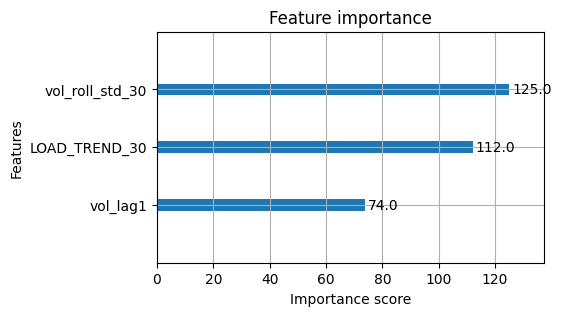

In [144]:
plt.rcParams["figure.figsize"] = (5, 3)
xgb.plot_importance(model);

## Validation

In [145]:
# =============================================================================
# Proper Evaluation Metrics
# =============================================================================

def evaluate_predictions(predictions, df):
    """
    Evaluate prediction quality 
    
    Metrics:
    - Information Coefficient (IC)
    - IC time-series stability
    - Hit rate (sign accuracy)
    - Per-country IC
    """
    # Merge predictions with full data
    eval_df = predictions.merge(
        df[['DAY_ID', 'COUNTRY', 'volatility', 'garch_vol']],
        on=['DAY_ID', 'COUNTRY'],
        how='left'
    )
    
    metrics = {}
    
    # Overall IC
    overall_ic = spearmanr(eval_df['pred_residual'], eval_df['true_residual']).correlation
    metrics['overall_ic'] = overall_ic
    
    # Daily IC (time-series stability)
    daily_ic = eval_df.groupby('DAY_ID').apply(
        lambda x: spearmanr(x['pred_residual'], x['true_residual']).correlation
        if len(x) >= 2 else np.nan
    ).dropna()
    
    metrics['mean_daily_ic'] = daily_ic.mean()
    metrics['std_daily_ic'] = daily_ic.std()
    metrics['ic_t_stat'] = (daily_ic.mean() / daily_ic.std()) * np.sqrt(len(daily_ic)) if len(daily_ic) > 0 else 0
    
    # Hit rate (sign accuracy)
    eval_df['pred_sign'] = np.sign(eval_df['pred_residual'])
    eval_df['true_sign'] = np.sign(eval_df['true_residual'])
    hit_rate = (eval_df['pred_sign'] == eval_df['true_sign']).mean()
    metrics['hit_rate'] = hit_rate
    
    # Per-country IC
    country_ic = eval_df.groupby('COUNTRY').apply(
        lambda x: spearmanr(x['pred_residual'], x['true_residual']).correlation
    )
    metrics['country_ic'] = country_ic.to_dict()
    
    log.info("=== Prediction Quality ===")
    log.info(f"Overall IC: {overall_ic:.4f}")
    log.info(f"Mean Daily IC: {metrics['mean_daily_ic']:.4f} (±{metrics['std_daily_ic']:.4f})")
    log.info(f"IC t-stat: {metrics['ic_t_stat']:.2f}")
    log.info(f"Hit Rate: {hit_rate:.2%}")
    for country, ic in country_ic.items():
        log.info(f"  {country} IC: {ic:.4f}")
    
    return metrics, daily_ic

## Trading strategy

In [102]:
# =============================================================================
# Market-Neutral Trading Strategy
# =============================================================================

def compute_market_neutral_pnl(bt, threshold=0.5, cost_bps=0.0005, lookback=30):
    """
    CORRECTED market-neutral volatility residual trading strategy
    
    Key fix: PnL is realized on RAW residuals, not demeaned residuals!
    
    Strategy:
    1. Predict volatility residual (pred_vol - garch_vol)
    2. Normalize predictions to z-scores per country
    3. Create market-neutral positions (sum to 0 each day)
    4. Realize PnL from actual residuals (NOT demeaned)
    
    Parameters:
    -----------
    bt : DataFrame with columns ['DAY_ID', 'COUNTRY', 'pred_residual', 'true_residual']
    threshold : z-score threshold for signals
    cost_bps : transaction cost in basis points (0.0005 = 5 bps)
    lookback : window for z-score normalization
    
    Returns:
    --------
    bt : DataFrame with positions and PnL
    """
    bt = bt.copy()
    bt = bt.sort_values(['COUNTRY', 'DAY_ID']).reset_index(drop=True)
    
    # =============================================================================
    # Step 1: Z-score normalization per country
    # =============================================================================
    # Compute rolling mean and std of predictions (per country, backward-looking)
    bt['pred_mean_past'] = bt.groupby('COUNTRY')['pred_residual'].transform(
        lambda x: x.rolling(lookback, min_periods=5).mean().shift(1)
    )
    bt['pred_std_past'] = bt.groupby('COUNTRY')['pred_residual'].transform(
        lambda x: x.rolling(lookback, min_periods=5).std().shift(1)
    )
    
    # Handle missing/zero std
    bt['pred_std_past'] = bt['pred_std_past'].fillna(
        bt.groupby('COUNTRY')['pred_std_past'].transform('median')
    )
    bt['pred_std_past'] = bt['pred_std_past'].replace(0, 1e-6)
    
    # Compute z-scores
    bt['z'] = (bt['pred_residual'] - bt['pred_mean_past']) / bt['pred_std_past']
    bt['z'] = bt['z'].fillna(0)
    
    # =============================================================================
    # Step 2: Generate signals with threshold
    # =============================================================================
    # Only trade when |z| > threshold (filter out weak signals)
    bt['signal_raw'] = np.where(bt['z'].abs() > threshold, bt['z'], 0)
    
    # Clip extreme signals
    bt['signal'] = bt['signal_raw'].clip(-2, 2)
    
    # =============================================================================
    # Step 3: Market-neutral position sizing
    # =============================================================================
    # CRITICAL: Make positions sum to zero within each day (market neutral)
    # Method: demean signals, then normalize
    
    # Cross-sectionally demean signals (makes them sum to 0)
    bt['signal_cs'] = bt['signal'] - bt.groupby('DAY_ID')['signal'].transform('mean')
    
    # Normalize so total absolute exposure = 1 per day
    daily_abs_sum = bt.groupby('DAY_ID')['signal_cs'].transform(lambda x: x.abs().sum())
    daily_abs_sum = daily_abs_sum.replace(0, np.nan)
    
    bt['position'] = bt['signal_cs'] / daily_abs_sum
    bt['position'] = bt['position'].fillna(0)
    
    # Verify market neutrality (positions should sum to ~0 each day)
    daily_pos_sum = bt.groupby('DAY_ID')['position'].sum()
    if not (daily_pos_sum.abs() < 1e-8).all():
        log.warning("Positions are not market neutral! Max deviation: {:.2e}".format(
            daily_pos_sum.abs().max()))
    
    # =============================================================================
    # Step 4: Compute PnL on RAW residuals (THIS IS THE KEY FIX!)
    # =============================================================================
    # We trade the prediction, realize the ACTUAL residual (not demeaned!)
    # This is what was wrong in the original code
    
    bt['pnl_before_cost'] = bt['position'] * bt['true_residual']
    
    # =============================================================================
    # Step 5: Transaction costs
    # =============================================================================
    bt['prev_pos'] = bt.groupby('COUNTRY')['position'].shift(1).fillna(0)
    bt['turnover'] = (bt['position'] - bt['prev_pos']).abs()
    bt['tcost'] = bt['turnover'] * cost_bps
    
    # =============================================================================
    # Step 6: Net PnL
    # =============================================================================
    bt['pnl'] = bt['pnl_before_cost'] - bt['tcost']
    
    return bt


def compute_cross_sectional_pnl(bt, cost_bps=0.0005):
    """
    Alternative: Pure cross-sectional relative value strategy
    
    This strategy trades the RELATIVE difference between countries
    each day, and realizes cross-sectional returns.
    
    Use this if you believe your signal predicts relative outperformance,
    not absolute levels.
    """
    bt = bt.copy()
    bt = bt.sort_values(['COUNTRY', 'DAY_ID']).reset_index(drop=True)
    
    # Rank predictions within each day (0 to 1)
    bt['pred_rank'] = bt.groupby('DAY_ID')['pred_residual'].rank(pct=True)
    
    # Signal: long top, short bottom
    # Example: top 40% = +1, bottom 40% = -1, middle 20% = 0
    bt['signal'] = np.where(bt['pred_rank'] > 0.6, 1,
                   np.where(bt['pred_rank'] < 0.4, -1, 0))
    
    # Ensure market neutral
    bt['position'] = bt['signal'] - bt.groupby('DAY_ID')['signal'].transform('mean')
    
    # Normalize
    daily_abs = bt.groupby('DAY_ID')['position'].transform(lambda x: x.abs().sum())
    bt['position'] = bt['position'] / daily_abs.replace(0, np.nan)
    bt['position'] = bt['position'].fillna(0)
    
    # PnL: Now we DO use cross-sectional returns (relative to daily mean)
    bt['true_res_cs'] = bt['true_residual'] - bt.groupby('DAY_ID')['true_residual'].transform('mean')
    bt['pnl_before_cost'] = bt['position'] * bt['true_res_cs']
    
    # Costs
    bt['prev_pos'] = bt.groupby('COUNTRY')['position'].shift(1).fillna(0)
    bt['turnover'] = (bt['position'] - bt['prev_pos']).abs()
    bt['tcost'] = bt['turnover'] * cost_bps
    bt['pnl'] = bt['pnl_before_cost'] - bt['tcost']
    
    return bt

In [115]:
# Build backtest table from df rows that have predictions
bt = df.loc[df['pred_residual'].notna(), ['DAY_ID', 'COUNTRY', 'pred_residual', 'true_residual', 'volatility']].copy()
bt = compute_market_neutral_pnl(bt)

In [126]:
def evaluate_trading_performance(bt):
    """
    Evaluate trading strategy performance
    
    Metrics:
    - Sharpe ratio
    - Max drawdown
    - Turnover
    - Win rate
    """
    # Daily PnL
    daily_pnl = bt.groupby('DAY_ID')['pnl'].sum()
    
    # Sharpe (annualized, assuming 252 trading days)
    sharpe = (daily_pnl.mean() / (daily_pnl.std() + 1e-9)) * np.sqrt(252)
    
    # Max drawdown
    cum_pnl = daily_pnl.cumsum()
    roll_max = cum_pnl.cummax()
    drawdown = cum_pnl - roll_max
    max_dd = drawdown.min()
    
    # Turnover
    avg_daily_turnover = bt.groupby('DAY_ID')['turnover'].sum().mean()
    
    # Win rate
    win_rate = (daily_pnl > 0).mean()
    
    # PnL statistics
    total_pnl = daily_pnl.sum()
    total_cost = bt['tcost'].sum()
    
    metrics = {
        'sharpe': sharpe,
        'max_drawdown': max_dd,
        'avg_daily_turnover': avg_daily_turnover,
        'win_rate': win_rate,
        'total_pnl': total_pnl,
        'total_cost': total_cost,
        'pnl_before_cost': bt['pnl_before_cost'].sum(),
        'n_days': len(daily_pnl)
    }
    
    log.info("=== Trading Performance ===")
    log.info(f"Sharpe Ratio: {sharpe:.4f}")
    log.info(f"Max Drawdown: {max_dd:.4f}")
    log.info(f"Win Rate: {win_rate:.2%}")
    log.info(f"Avg Daily Turnover: {avg_daily_turnover:.4f}")
    log.info(f"Total PnL: {total_pnl:.6f}")
    log.info(f"Total Cost: {total_cost:.6f}")
    log.info(f"PnL Before Cost: {metrics['pnl_before_cost']:.6f}")
    
    return metrics, daily_pnl

In [128]:
res = evaluate_trading_performance(bt)

2026-02-10 15:54:11,506 INFO === Trading Performance ===
2026-02-10 15:54:11,507 INFO Sharpe Ratio: 0.8224
2026-02-10 15:54:11,508 INFO Max Drawdown: -15.3469
2026-02-10 15:54:11,508 INFO Win Rate: 34.92%
2026-02-10 15:54:11,509 INFO Avg Daily Turnover: 0.5159
2026-02-10 15:54:11,509 INFO Total PnL: 9.625463
2026-02-10 15:54:11,510 INFO Total Cost: 0.065000
2026-02-10 15:54:11,510 INFO PnL Before Cost: 9.690463


In [134]:
daily_pnl = bt.groupby('DAY_ID')['pnl'].sum()
print(daily_pnl.quantile([0.1, 0.25, 0.5, 0.75, 0.9]))

left = abs(daily_pnl.quantile(0.1))
right = daily_pnl.quantile(0.9)
print("Asymmetry ratio (right/left):", right/left)

0.10   -0.899836
0.25   -0.224565
0.50    0.000000
0.75    0.397701
0.90    0.959766
Name: pnl, dtype: float64
Asymmetry ratio (right/left): 1.06660137773223


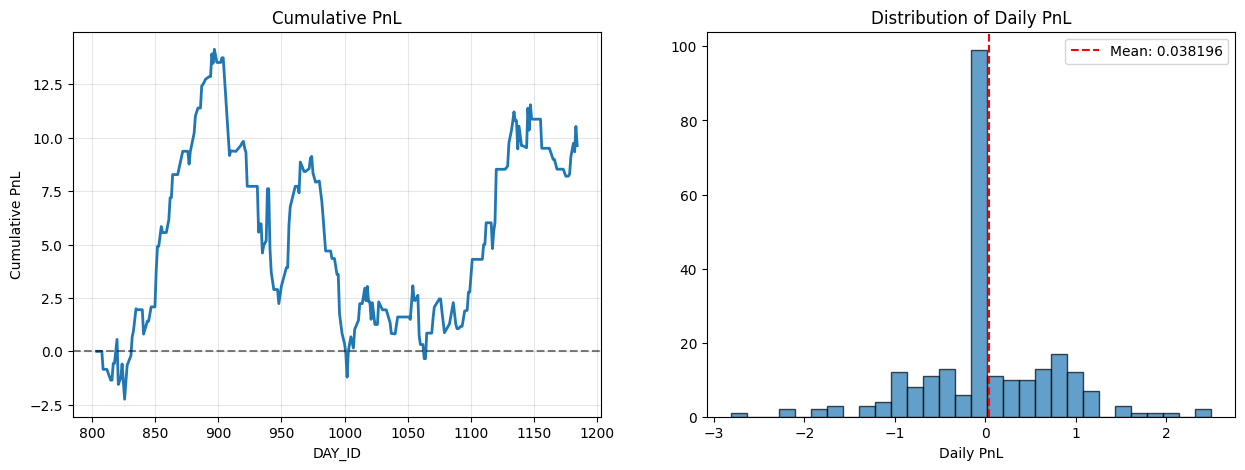

In [142]:
# 3. Cumulative PnL
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
cum_pnl = daily_pnl.cumsum()
cum_pnl.plot(ax=axes[0], title='Cumulative PnL', linewidth=2)
axes[0].axhline(0, color='black', linestyle='--', alpha=0.5)
axes[0].set_ylabel('Cumulative PnL')
axes[0].grid(True, alpha=0.3)

# 4. Daily PnL distribution
axes[1].hist(daily_pnl.dropna(), bins=30, edgecolor='black', alpha=0.7)
axes[1].axvline(daily_pnl.mean(), color='red', linestyle='--',
                   label=f'Mean: {daily_pnl.mean():.6f}')
axes[1].set_title('Distribution of Daily PnL')
axes[1].set_xlabel('Daily PnL')
axes[1].legend();